# Checking bias classifying facial emotions: models trained on imagenet

In this work a <a href="https://github.com/atulapra/Emotion-detection">pre-trained neural network</a> with 20000 photos from the FERC2013 dataset will be used, aiming to recognize emotions in the <a href="https://github.com/joojs/fairfacehttps://github.com/joojs/fairface">FairFace</a> images, observing the disparity of the predictions regarding the composition of the dataset demographic.

In [1]:
"""
    Requirements to execute code
"""

# ! python3 -m pip install nltk
# ! python3 -m pip install mtcnn
# ! python3 -m pip install cv2
# ! python3 -m pip install keras
# ! python3 -m pip install numpy
# ! python3 -m pip install pandas
# ! python3 -m pip install cv2
# ! python3 -m pip install regex


'\n    Requirements to execute code\n'

In [2]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D
from keras.optimizers import Adam
from keras.layers.pooling import MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator

import os
# import cv2
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize']  = (10, 8)
plt.rcParams['axes.labelsize']  = 12
plt.rcParams['axes.titlesize']  = 16
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

Using TensorFlow backend.


In [3]:
plt.ion()

plt.style.use('seaborn-colorblind')
plt.rcParams['figure.figsize']  = (12, 10)

## Classifying facial emotions 

In [ ]:
"""
    Importing Pre-Trained  face recognition model.
    Font article : https://github.com/atulapra/Emotion-detection/blob/master/ResearchPaper.pdf
"""

# Create the model
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48,48,1)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))

# Import values for model
model.load_weights('model/model.h5')   

# Folder of faces images
path = 'fairface-img-margin125-trainval/train/'

# List of faces images
images_list = os.listdir(path)

# List of Classifiable Emotions
emotion_dict = {0: "Angry", 1: "Disgusted", 2: "Fearful", 3: "Happy", 4: "Neutral", 5: "Sad", 6: "Surprised"}

# Dictionary for save results
dictResult = {}
resultImage = {}
i = 0

# Process list of face images
for file in images_list:
    nameFile = path+file
    # Warning execution
    if i % 1000 == 0:
        print("{}/{}- file:{}".format(i,len(images_list),nameFile))
    
    # Converting image to numeric array
    face_image  = cv2.imread(nameFile)
    face_image = cv2.resize(face_image, (48,48))
    face_image = cv2.cvtColor(face_image, cv2.COLOR_BGR2GRAY)
    face_image = np.reshape(face_image, [1, face_image.shape[0], face_image.shape[1], 1])
    
    # Predtion for face image
    predicted_class = np.argmax(model.predict(face_image))
    predicted_label = emotion_dict [predicted_class]
    
    # Save result of prediction
    if predicted_label in dictResult:
        dictResult[predicted_label] += 1
    else:
        dictResult.update({predicted_label: 1})
        
    resultImage.update({file: predicted_label})
    
    i += 1

# ALL: {'Angry': 9376, 'Sad': 17019, 'Happy': 24401, 'Fear': 22127, 'Disgust': 39, 'Neutral': 8428, 'Surprise': 5354}
# 1000 : {'Angry': 109, 'Sad': 217, 'Happy': 274, 'Fear': 246, 'Disgust': 1, 'Neutral': 90, 'Surprise': 63}

### Exporting results

In [ ]:
# Dataframe of labels
df = pd.read_csv('label/fairface_label_train.csv')
df.loc[:,"file"] = [x.replace('train/',"") for x in df.loc[:,"file"]]

data = {'file':list(resultImage.keys()), 'emotions':list(resultImage.values())}

# Dataframe of result
df_result = pd.DataFrame(data=data, columns=['file', 'emotions'])

# Join two files
df = pd.merge(df_result, df, how="outer", on="file")
df.head(5)

In [ ]:
# Saves result to your used later
df.to_csv('label/emotions-fairface.csv')

## Exploratory Data Analisys

### Importing and merging data frames

In [4]:
# Importing result images classification 
df = pd.read_csv('label/emotions-fairface.csv', index_col=0)
df.head(5)

,file,emotions,age,gender,race,service_test
0,1.jpg,Angry,50-59,Male,East Asian,True
1,10.jpg,Sad,30-39,Male,Middle Eastern,False
2,100.jpg,Happy,20-29,Female,East Asian,False
3,1000.jpg,Fear,30-39,Male,White,False
4,10000.jpg,Happy,50-59,Male,White,False


### Function for merge columns categories

In [5]:
def mergeForPlot(df, col_name, col_count='count', atribut_fix='emotions'):
    # Define labels for aixes X
    atribut_fix_list = list(df[atribut_fix].unique())

    # Set of col name
    labels = list(set(df[col_name]))
    labels.sort()
    
    # Define empty dataframe
    df_merge = pd.DataFrame({})

    for label in labels:

        # Group for colums 
        exp = col_name+' == "'+label +'"'
        data = df.query(exp)
        data = data[[atribut_fix,col_count]]
        data.columns = [atribut_fix,"Count "+label]

        if df_merge.shape[0] == 0:
            df_merge = data
        else:
            df_merge = pd.merge(df_merge,data, on=atribut_fix, how ="outer")
    
    return df_merge

### Population Measures

#### Gender

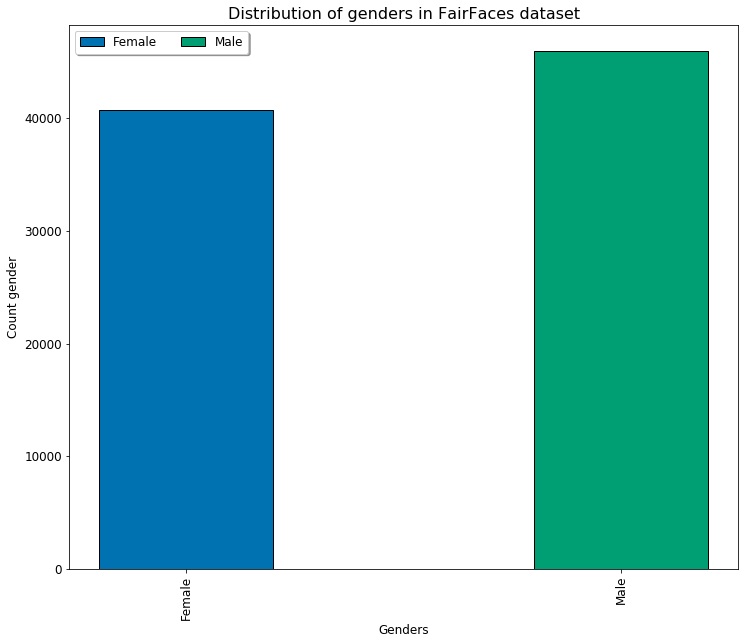

In [6]:
# Count gender in FairFaces Dataset
faces_gender = df[['gender',"file"]]
faces_gender.columns = ['gender',"count"]
faces_gender = faces_gender.groupby("gender",as_index=False).count()
gender_list = faces_gender['gender'].unique()

# Values
genders_list = faces_gender.iloc[:,0].values
values = faces_gender.iloc[:,1].values

# Ploting line by line
for unq_value in gender_list:
    mask = faces_gender['gender'] == unq_value
    df_subset = faces_gender[mask]
    plt.bar(df_subset['gender'], df_subset['count'], edgecolor='k',width=0.4)

# Config plot
plt.xticks(rotation=90)
plt.xlabel("Genders")
plt.ylabel("Count gender")
plt.title("Distribution of genders in FairFaces dataset")
plt.legend(gender_list, loc='upper left',  ncol=3, fancybox=True, shadow=True)
plt.show()

#### Race

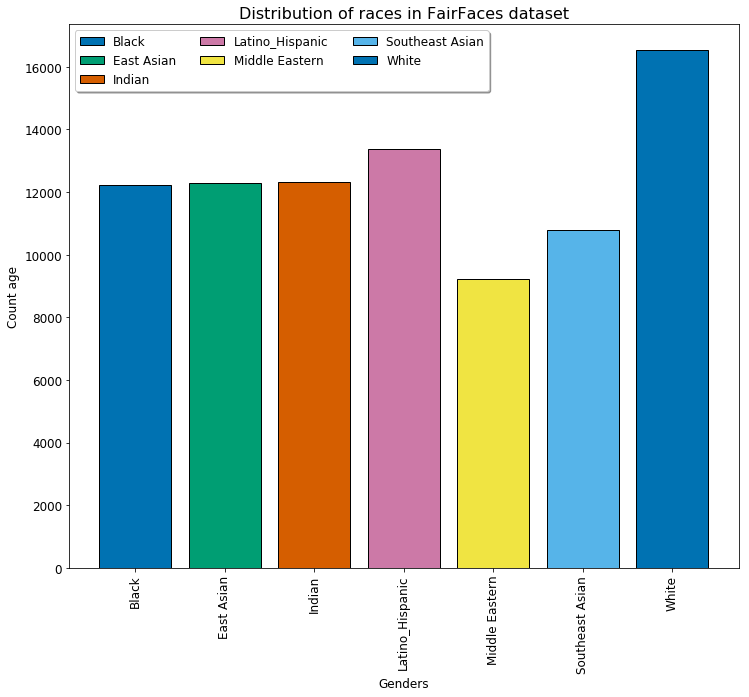

In [25]:
# Count gender in FairFaces Dataset
faces_race = df[['race',"file"]]
faces_race.columns = ['race',"count"]
faces_race = faces_race.groupby("race",as_index=False).count()
race_list = faces_race['race'].unique()

# Values
races_list = faces_race.iloc[:,0].values
values = faces_race.iloc[:,1].values

# Ploting line by line
for unq_value in race_list:
    mask = faces_race['race'] == unq_value
    df_subset = faces_race[mask]
    plt.bar(df_subset['race'], df_subset['count'], edgecolor='k')

# Config plot
plt.xticks(rotation=90)
plt.xlabel("Genders")
plt.ylabel("Count age")
plt.title("Distribution of races in FairFaces dataset")
plt.legend(race_list, loc='upper left',  ncol=3, fancybox=True, shadow=True)
plt.show()

#### Age

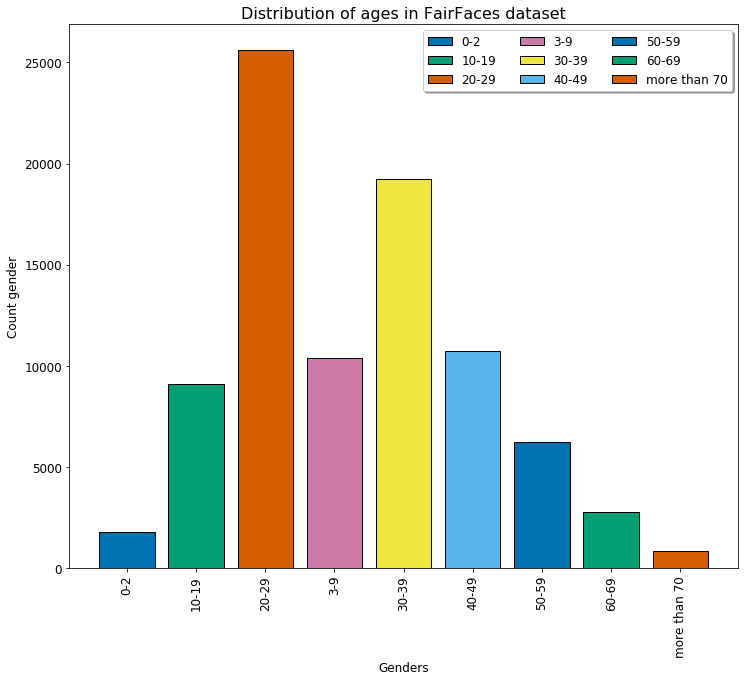

In [8]:
# Count gender in FairFaces Dataset
faces_age = df[['age',"file"]]
faces_age.columns = ['age',"count"]
faces_age = faces_age.groupby("age",as_index=False).count()
age_list = faces_age['age'].unique()

# Values
ages_list = faces_age.iloc[:,0].values
values = faces_age.iloc[:,1].values

# Ploting line by line
for unq_value in age_list:
    mask = faces_age['age'] == unq_value
    df_subset = faces_age[mask]
    plt.bar(df_subset['age'], df_subset['count'], edgecolor='k')

# Config plot
plt.xticks(rotation=90)
plt.xlabel("Genders")
plt.ylabel("Count gender")
plt.title("Distribution of ages in FairFaces dataset")
plt.legend(age_list, loc='upper right',  ncol=3, fancybox=True, shadow=True)
plt.show()

### Emotions Measures

#### Emotions for gender

In [9]:
df_gender = df.groupby(["emotions", "gender"], as_index=False).sum()
df_gender.columns = ["emotions", "gender", "count"]

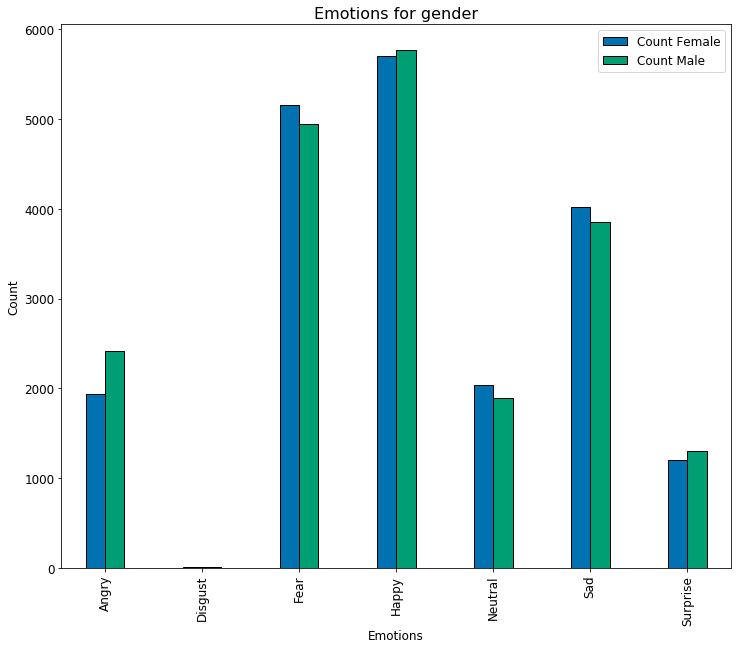

In [10]:
emotions_list = list(df_gender['emotions'].unique())

df_merge = mergeForPlot(df_gender,'gender')
plotResult = df_merge.plot.bar(
    width = 0.40, 
    edgecolor='k'
).set(
    xticklabels=emotions_list,
    title="Emotions for gender",
    xlabel='Emotions',
    ylabel="Count"
)

#### Emotions for races

In [11]:
df_race = df.groupby(["emotions", "race"], as_index=False).sum()
df_race.columns = ["emotions", "race", "count"]

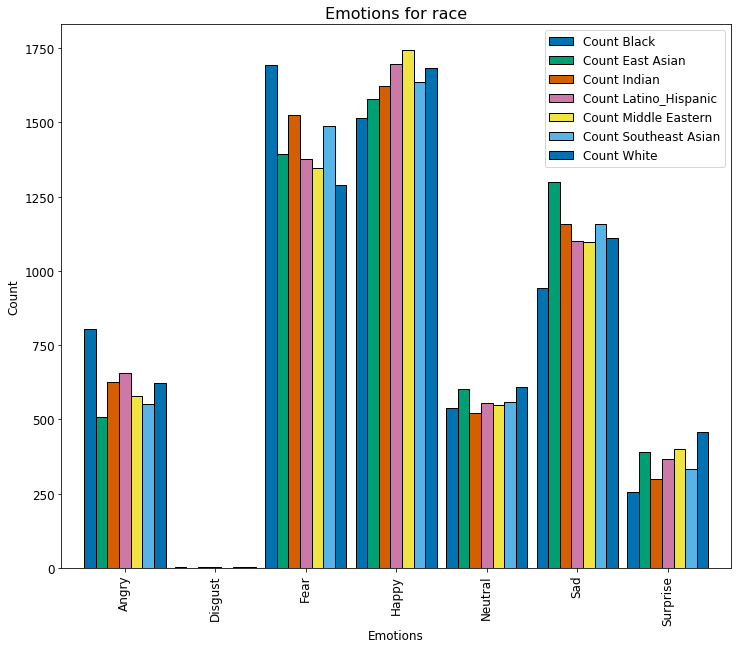

In [12]:
emotions_list = list(df_race['emotions'].unique())

df_merge = mergeForPlot(df_race,'race')
plotResult = df_merge.plot.bar(
    width = 0.90,
    edgecolor='k'
).set(
    xticklabels=emotions_list,
    title="Emotions for race",
    xlabel='Emotions',
    ylabel="Count"
)

#### Emotions for age

In [13]:
df_age = df.groupby(["emotions", "age"], as_index=False).sum()
df_age.columns = ["emotions", "age", "count"]

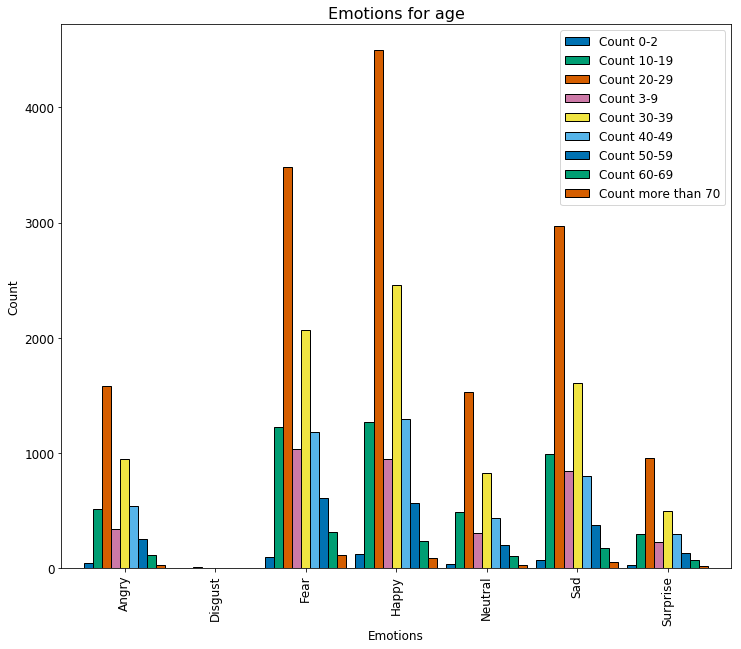

In [14]:
emotions_list = list(df_age['emotions'].unique())

df_merge = mergeForPlot(df_age,'age')
plotResult = df_merge.plot.bar(
    width = 0.90,
    edgecolor='k'
).set(
    xticklabels=emotions_list,
    title="Emotions for age",
    xlabel='Emotions',
    ylabel="Count"
)

#### Emotions for age and gender

In [15]:
df_age_gender = df.groupby(["emotions", "age", "gender"], as_index=False).sum()
df_age_gender.columns = ["emotions", "age", "gender","count"]

##### Gender: male

In [16]:
df_male = df_age_gender.query("gender == 'Male'")
df_female = df_age_gender.query("gender == 'Female'")

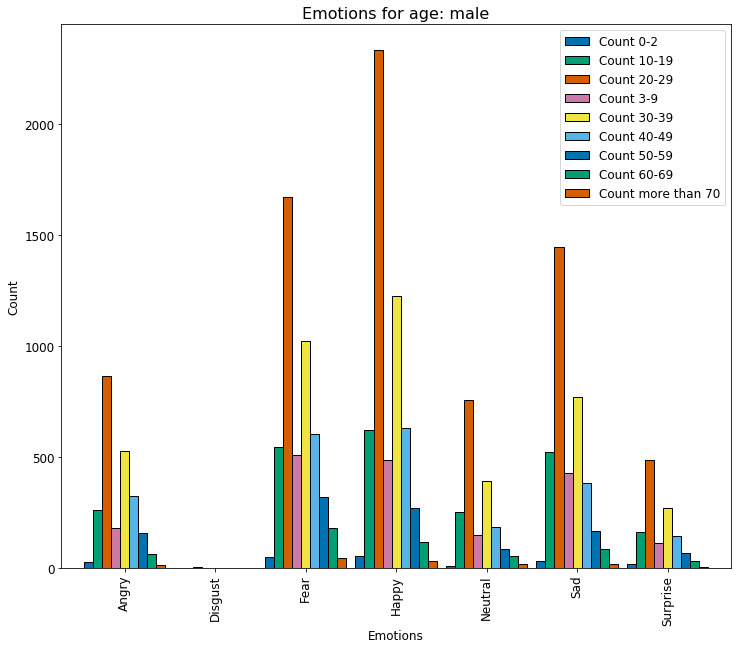

In [17]:
emotions_list = list(df_male['emotions'].unique())

df_merge = mergeForPlot(df_male,'age')
plotResult = df_merge.plot.bar(
    width = 0.90,
    edgecolor='k'
).set(
    xticklabels=emotions_list,
    title="Emotions for age: male",
    xlabel='Emotions',
    ylabel="Count"
)

##### Gender: female

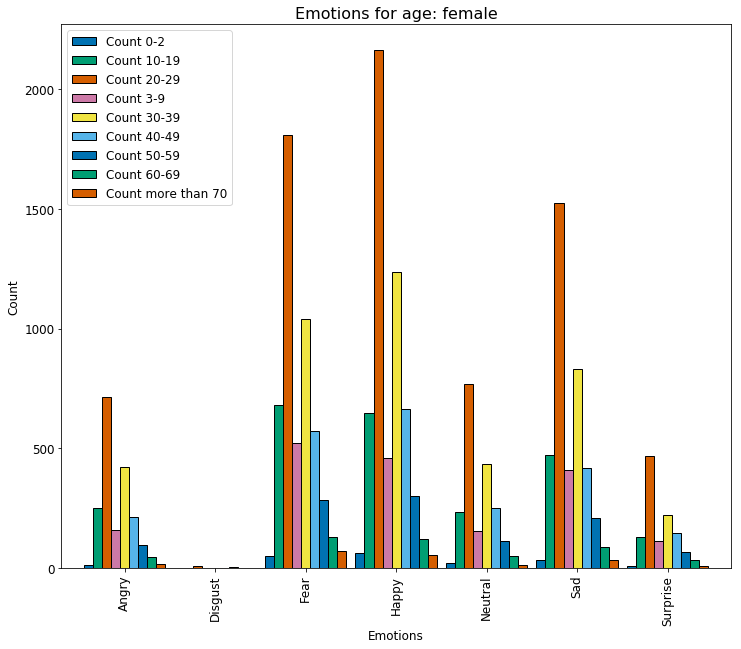

In [18]:
emotions_list = list(df_female['emotions'].unique())

df_merge = mergeForPlot(df_female,'age')
plotResult = df_merge.plot.bar(
    width = 0.90,
    edgecolor='k'
).set(
    xticklabels=emotions_list,
    title="Emotions for age: female",
    xlabel='Emotions',
    ylabel="Count"
)

#### Emotions for age and race

In [19]:
df_age_race = df.groupby(["emotions", "age", "race"], as_index=False).sum()
df_age_race.columns = ["emotions", "age", "race","count"]

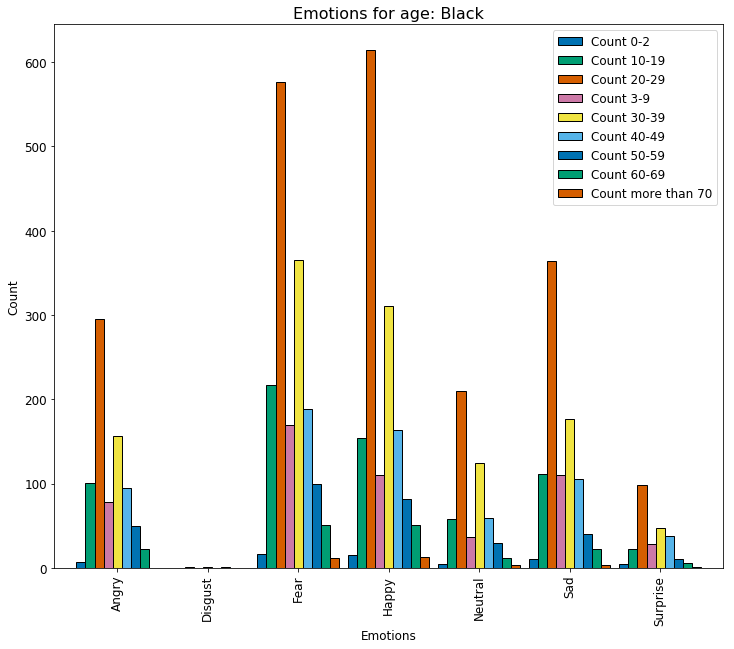

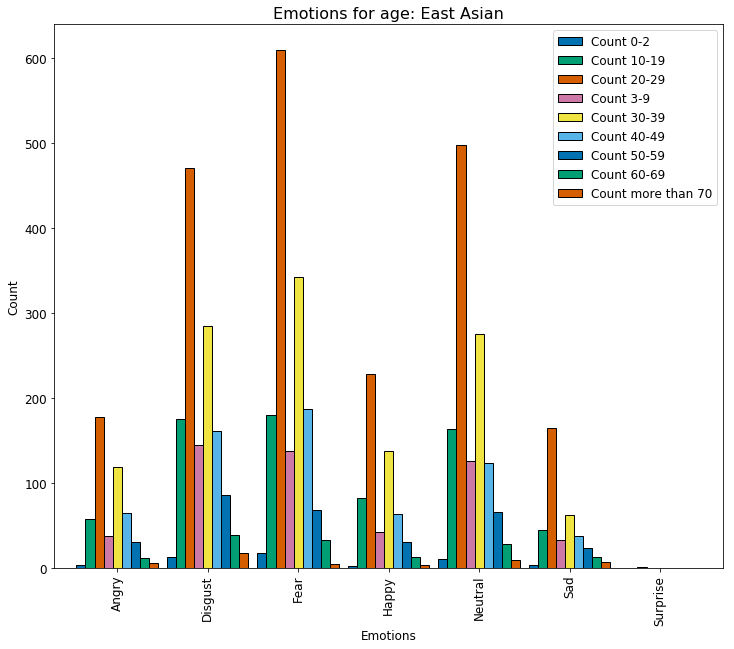

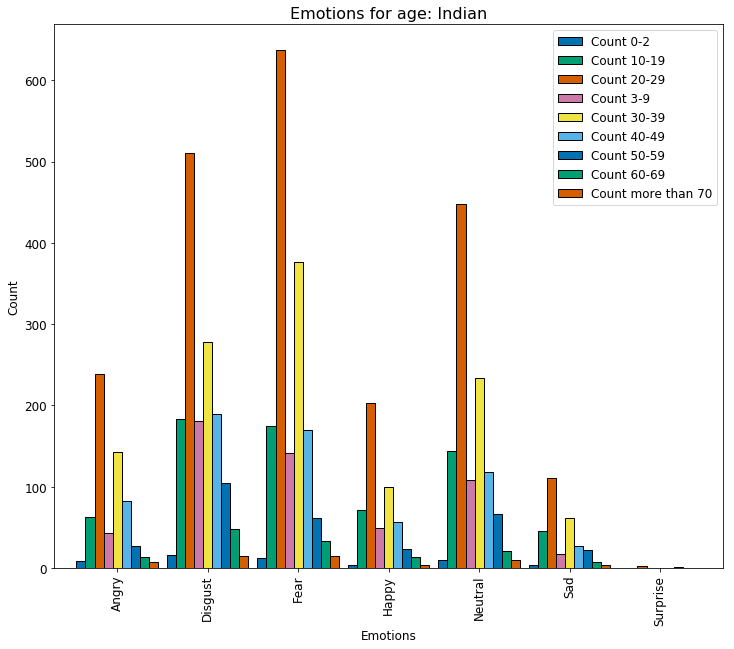

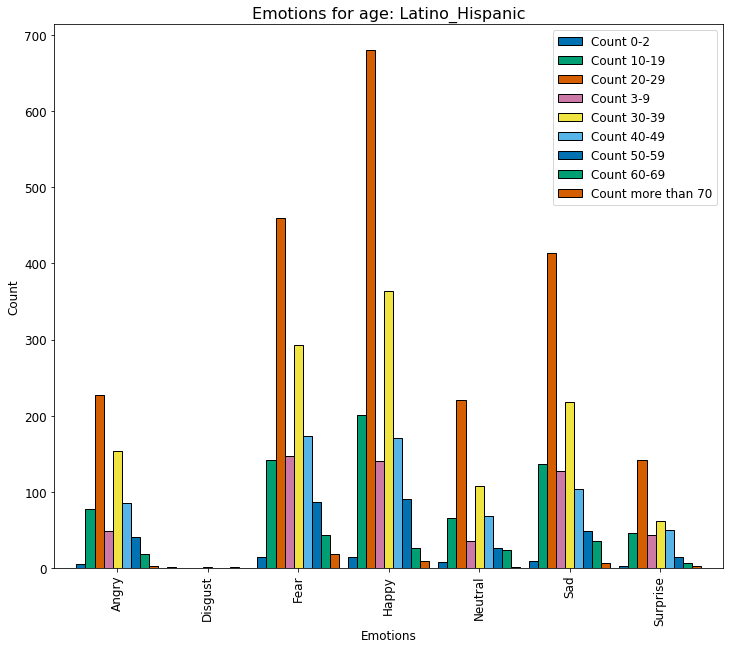

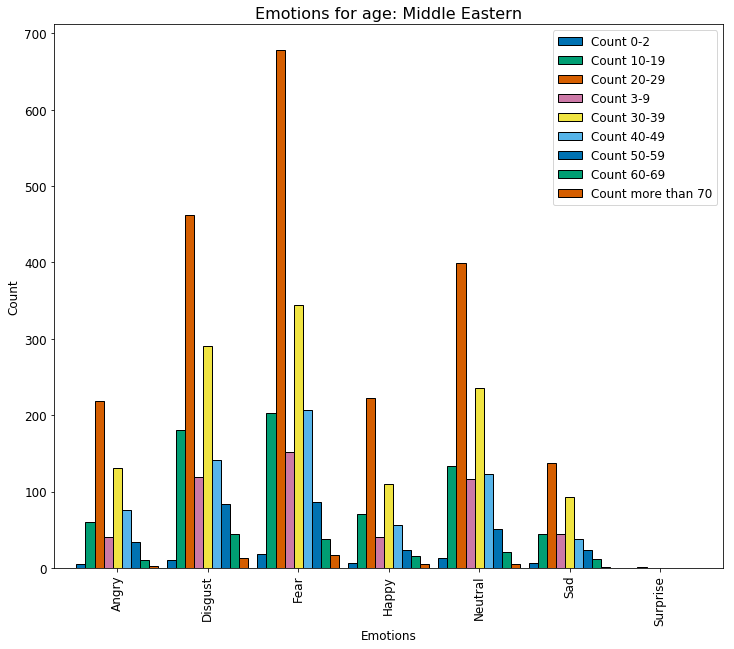

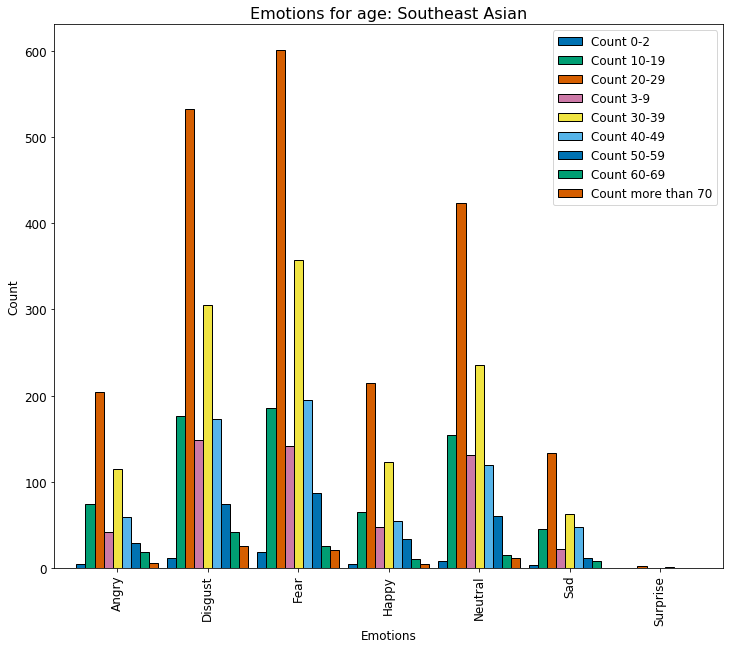

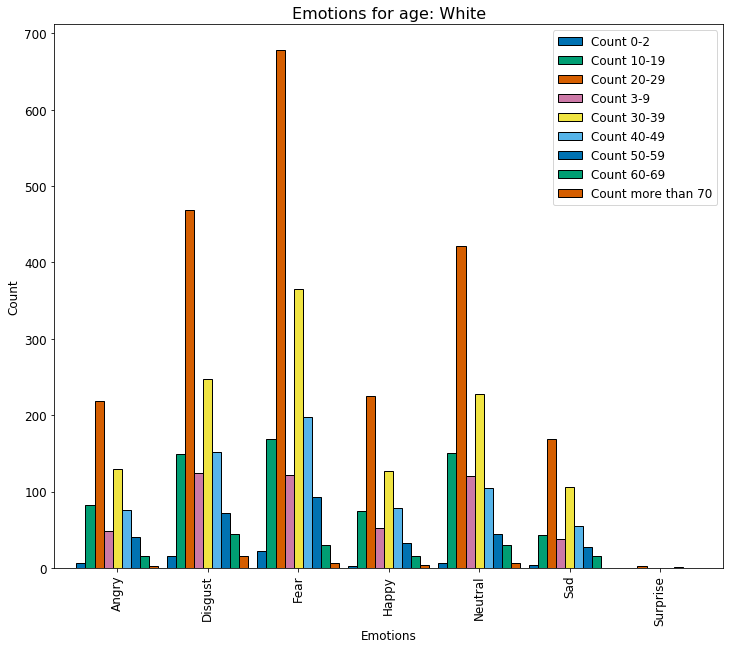

In [20]:
emotions_list = list(df_age_race['emotions'].unique())
races_list = list(df_age_race['race'].unique())

for race in races_list:
    exp = "race =='"+race+"'"
    
    a = df_age_race.query(exp)
    #display(a.groupby(["emotions","age", "race"], as_index=False).sum())
    #display(a.groupby(["emotions", "race"], as_index=False).sum())
    
    df_merge = mergeForPlot(df_age_race.query(exp),'age')
    plotResult = df_merge.plot.bar(
        width = 0.90,
        edgecolor='k'
    ).set(
        xticklabels=emotions_list,
        title="Emotions for age: "+race,
        xlabel='Emotions',
        ylabel="Count"
    )
    
    plt.show()
    df_merge = None

#### Emotions for age, race and gender

In [21]:
df_age_race_gender = df.groupby(["emotions", "age", "race","gender"], as_index=False).sum()
df_age_race_gender.columns = ["emotions", "age", "race","gender","count"]

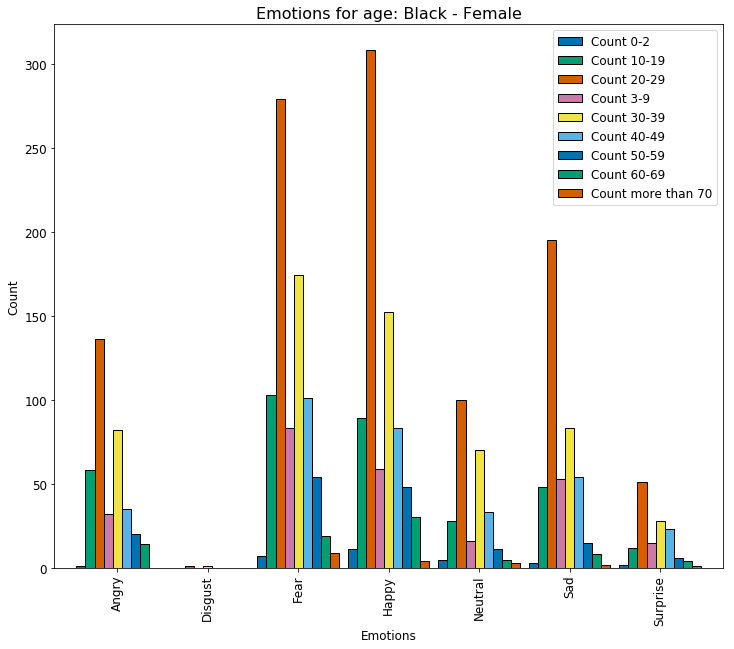

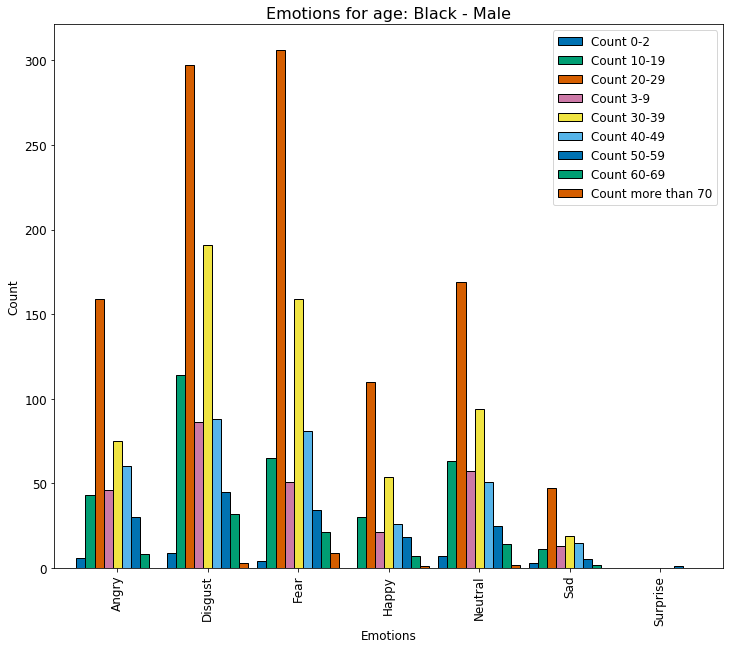

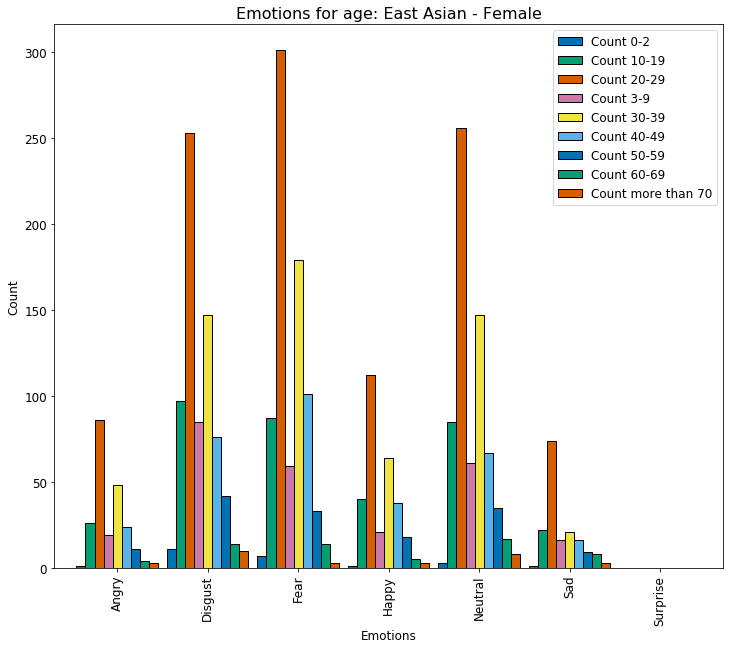

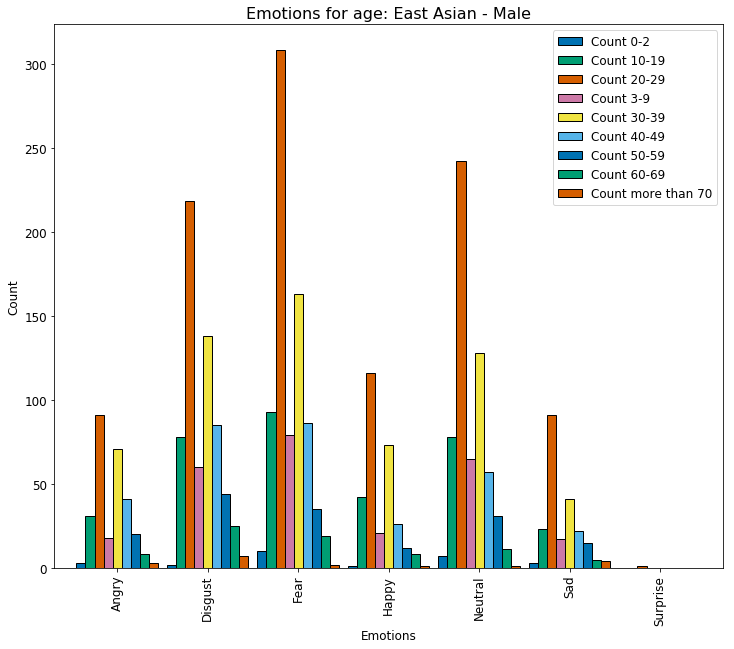

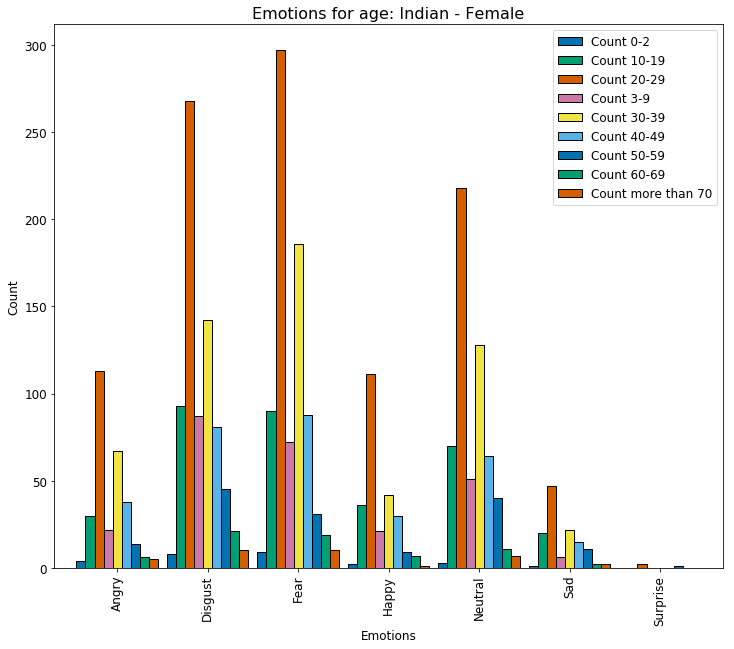

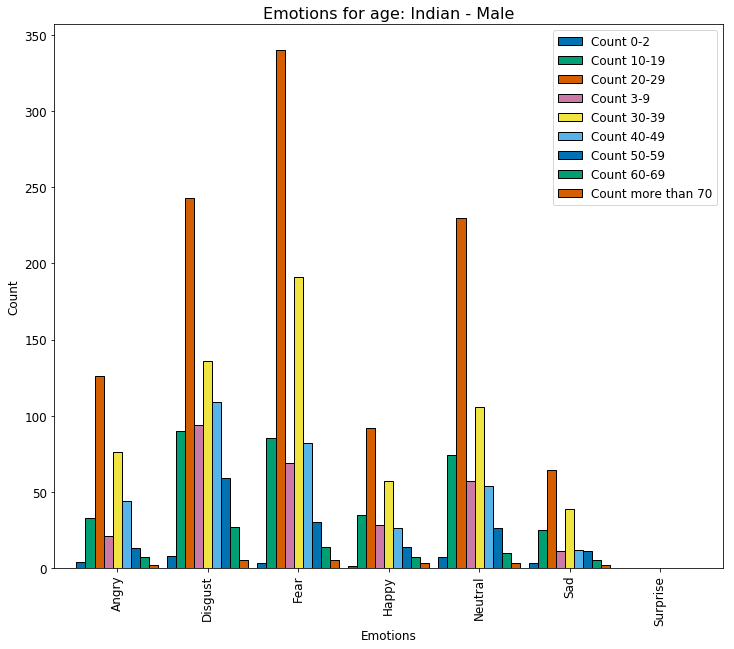

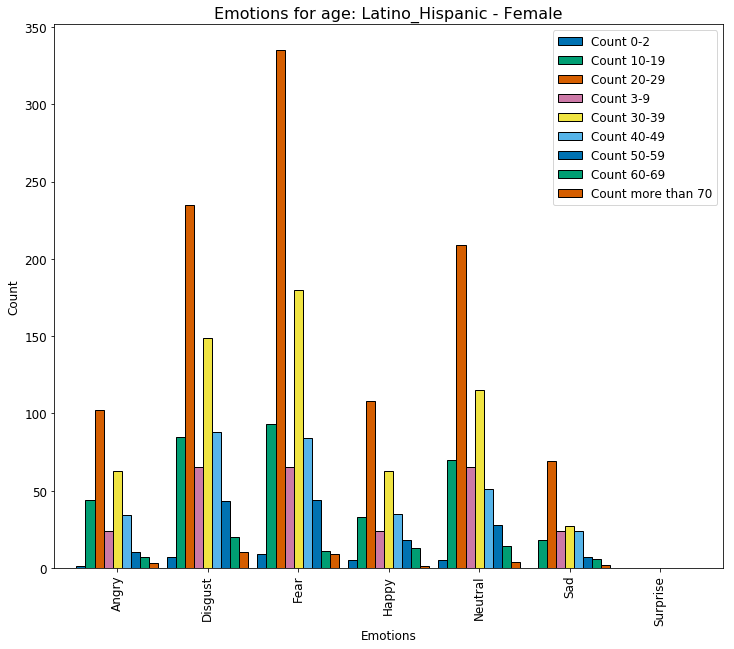

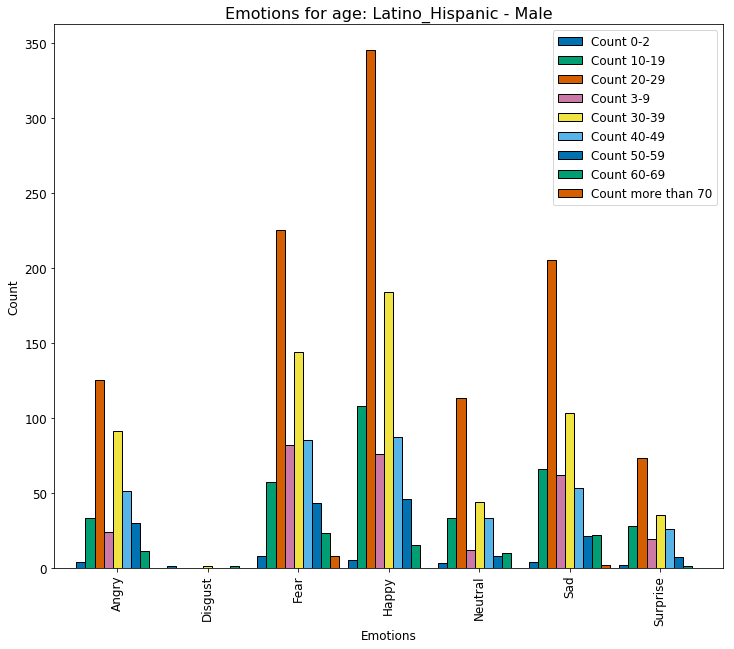

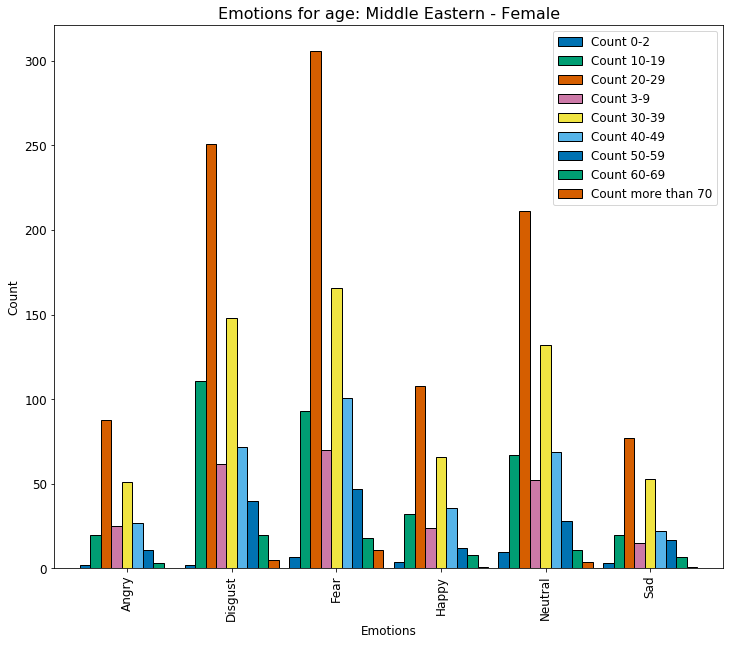

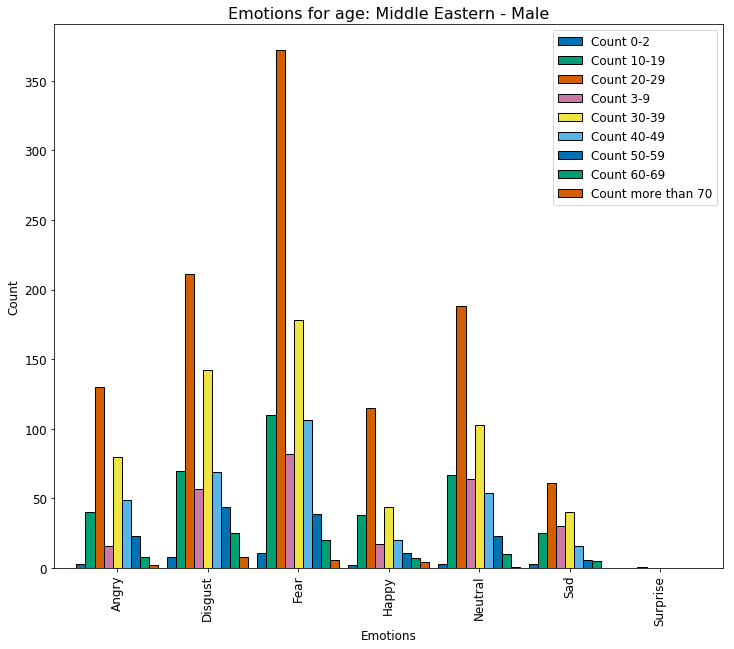

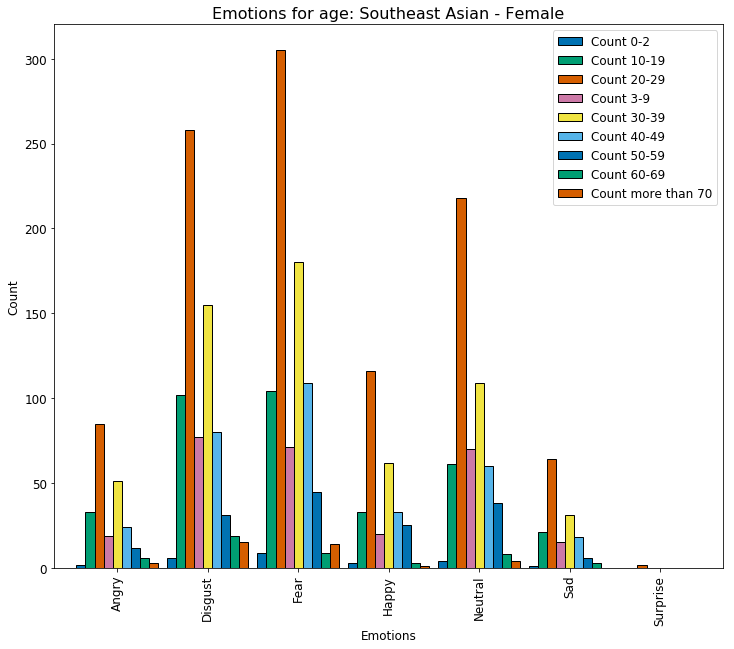

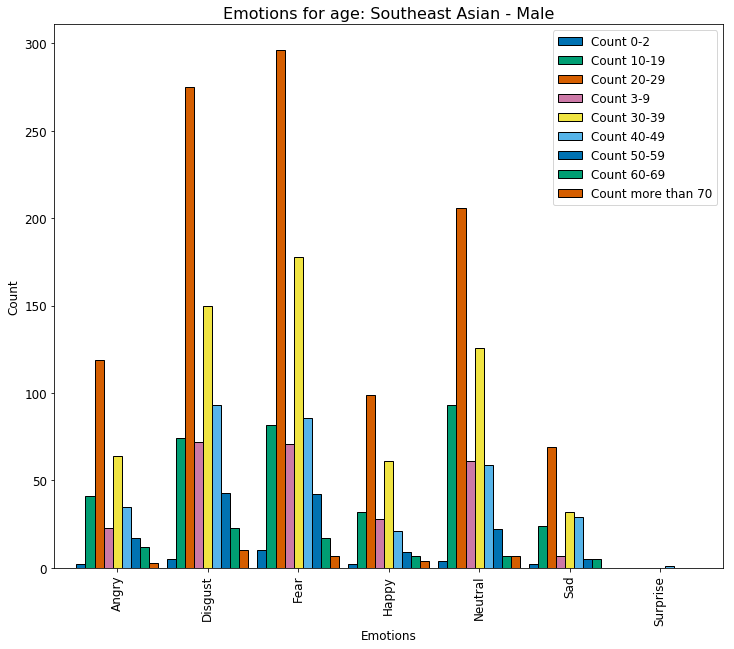

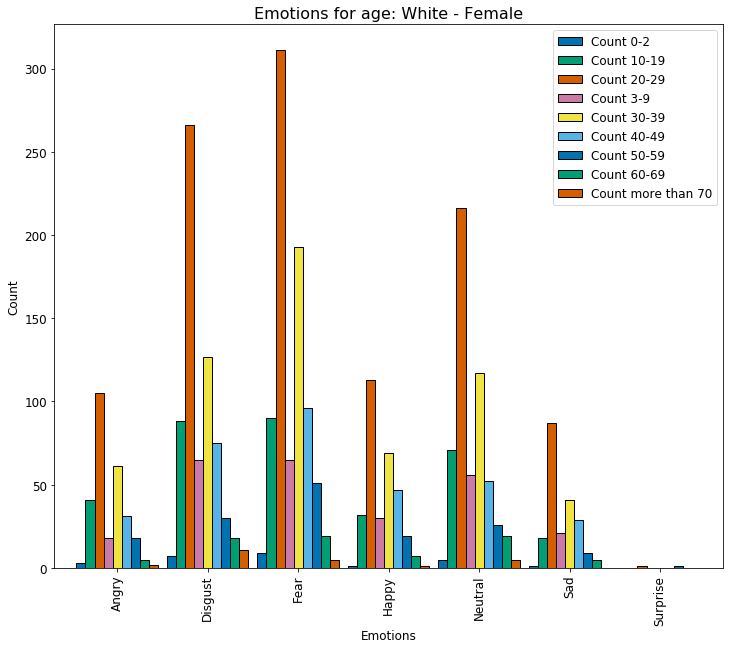

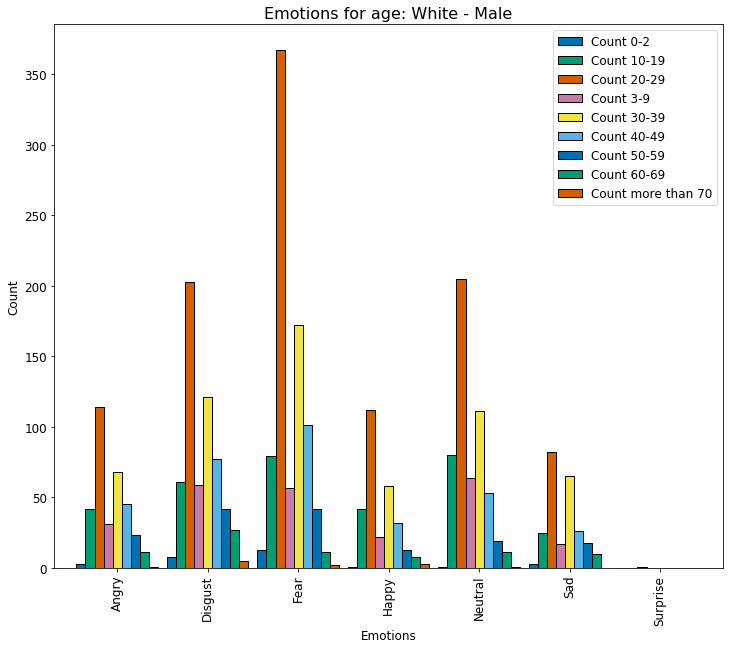

In [22]:
emotions_list = list(df_age_race_gender['emotions'].unique())
races_list = list(df_age_race_gender['race'].unique())
gender_list = list(df_age_race_gender['gender'].unique())

for race in races_list:
    for gender in gender_list:
        
        exp1 = "race =='"+race+"'"
        exp2 = "gender =='"+gender+"'"
        
        df_merge = mergeForPlot(df_age_race_gender.query(exp1).query(exp2),'age')
        plotResult = df_merge.plot.bar(
            width = 0.90,
            edgecolor='k'
        ).set(
            xticklabels=emotions_list,
            title="Emotions for age: "+race+" - "+gender,
            xlabel='Emotions',
            ylabel="Count"
        )
        
        plt.show()
        df_merge = None

## Calculating confidence intervals

Probability of probabilities

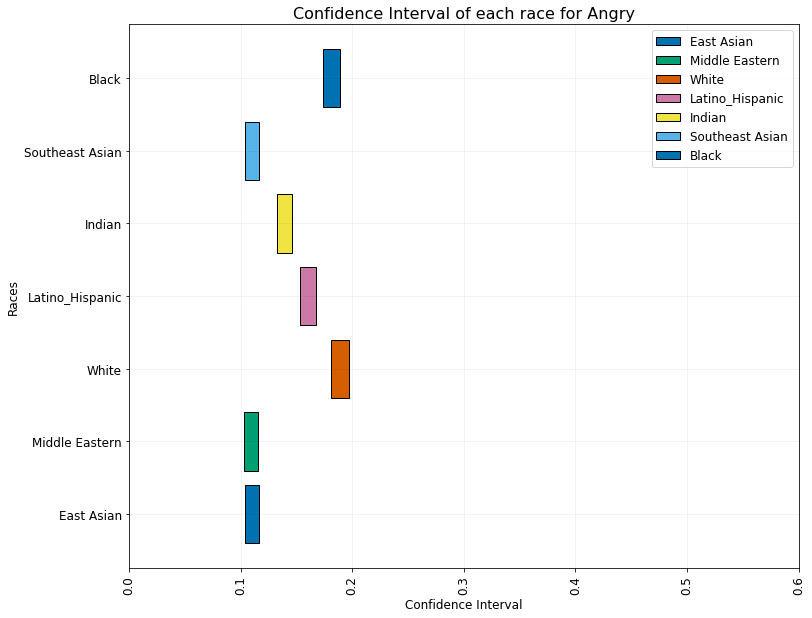

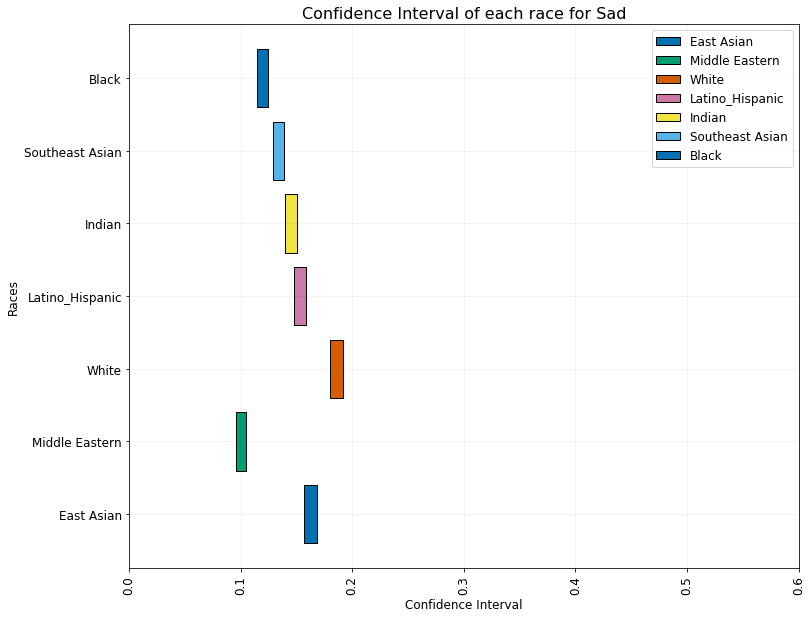

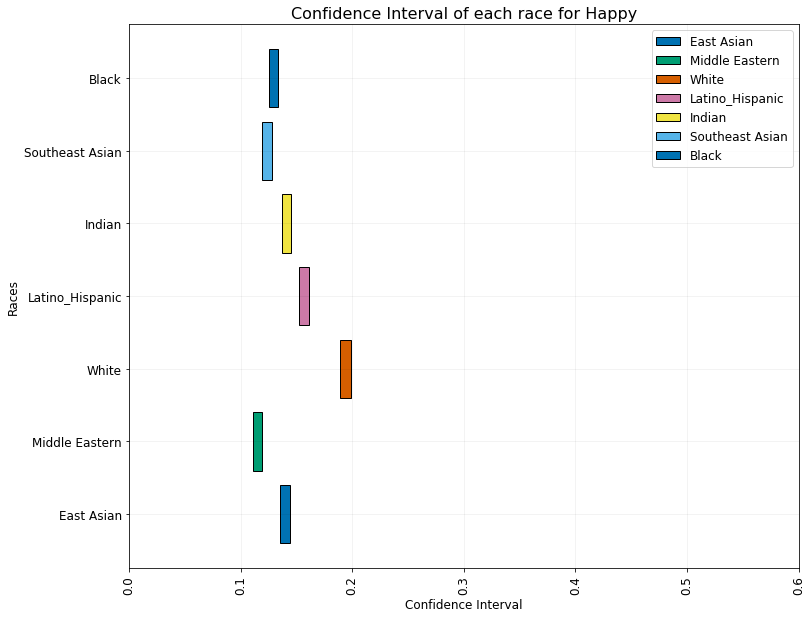

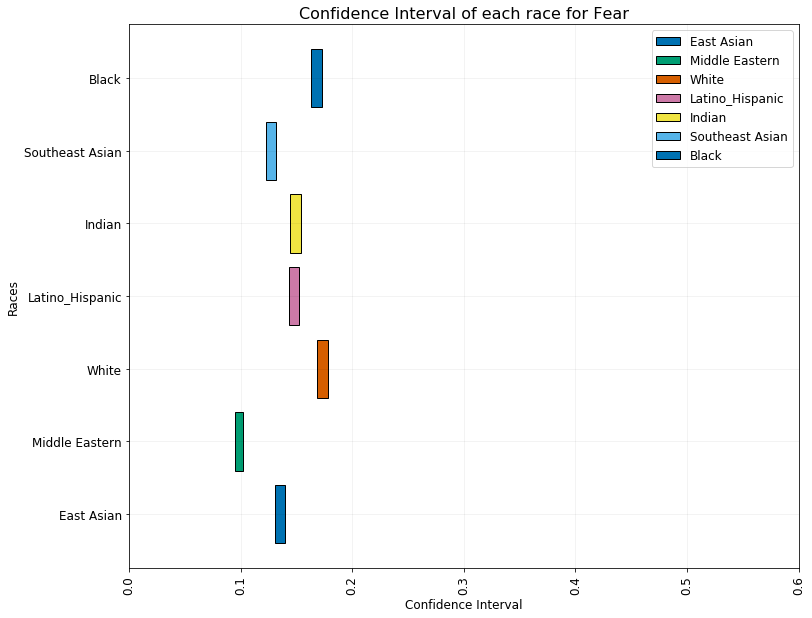

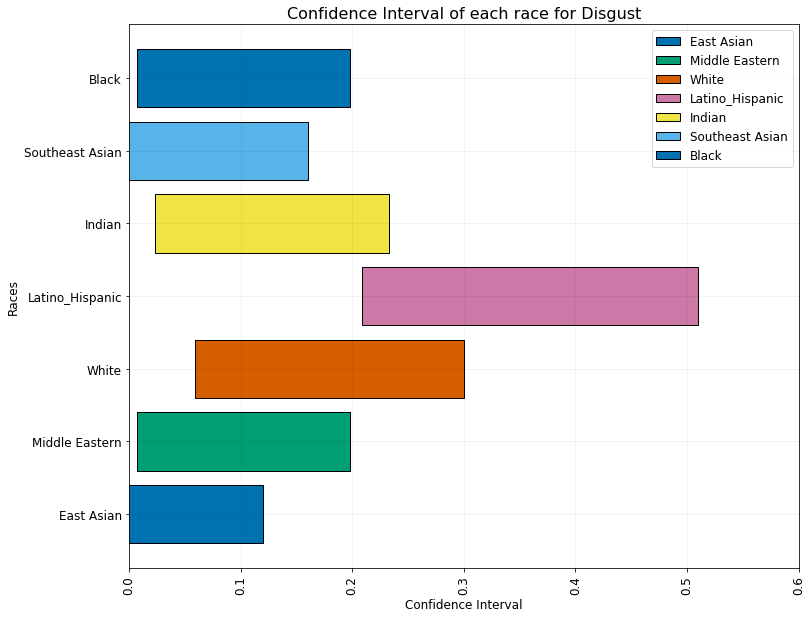

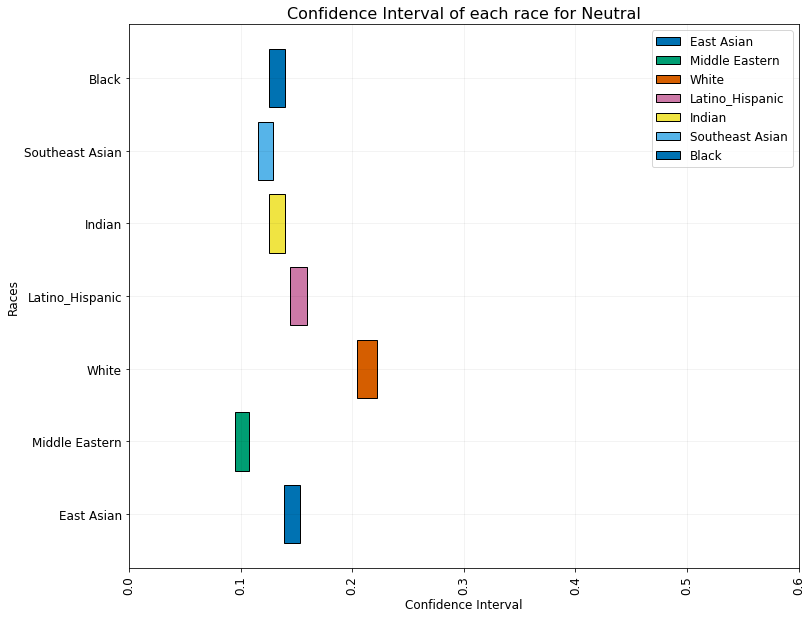

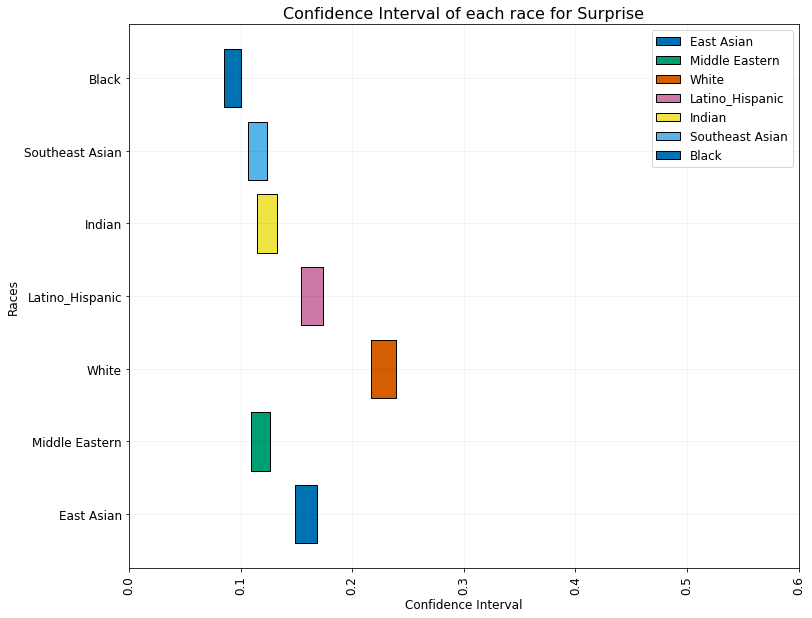

In [23]:
emotions_list = df['emotions'].unique()
race_list = df['race'].unique()

for emotion in emotions_list:
    confidence_intervals = {}
    
    #for plotting
    bar_start = []
    bar_end = []
    
    n = len(df[df['emotions'] == emotion])
    for race in race_list:
        
        p = len(df[(df['emotions'] == emotion) & (df['race'] == race)])
        p = p/n
        
        #using formula for calculating confidence intervals with
        #discrete variables, using the Adjusted Wald technique
        c_interval = np.zeros(2)
        offset = 1.96*(np.sqrt(p*(1-p)/n))
        c_interval[1] = p + offset
        c_interval[0] = p - offset
        confidence_intervals[race] = c_interval
        
        #for plotting
        bar_start.append(c_interval[0])
        bar_end.append(c_interval[1] - c_interval[0])
            
    # Ploting line by line
    for i in range(len(race_list)):
        plt.barh(i, bar_end[i], 0.8, bar_start[i], edgecolor='k')
        
    # Config plot
    plt.xticks(rotation=90)
    plt.yticks(range(len(race_list)), race_list)
    plt.xlabel('Confidence Interval')
    plt.ylabel("Races")
    plt.title('Confidence Interval of each race for {}'.format(emotion))
    plt.legend(race_list, loc='upper right',  ncol=1 )
    plt.xlim(0, 0.6) 
    plt.grid(which='both', alpha=0.05, color='black',linewidth=0.9)
             
    plt.show()